In [1]:
import plot
import importlib
import numpy as np
import random
import os
import glob
import h5py
import math
import scipy
import random
import classify
import warnings
import preprocess
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from os import path
from scipy import stats
from scipy.io import loadmat
from matplotlib import gridspec
from numpy.linalg import norm
from scipy.spatial import distance
from sklearn import decomposition
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

np.random.seed(42)
random.seed(42)


In [2]:
# reload when updating code
importlib.reload(preprocess)
# mouse and date

mice = ['NN11'] 
dates_per_mouse = {'NN11': ['210626']}

for mouse in mice:
    dates = dates_per_mouse[mouse]  # Get the list of dates for the current mouse
    days = len(dates)  # Correct number of days for this mouse
    
    for day_idx, date in enumerate(dates):
        print(mouse, date)
        
        # Create folders to save files
        paths = preprocess.create_folders(mouse, date)
        print('folders created')
        
        # Import data for mouse and date as dict
        session_data = preprocess.load_data(paths)
        print('data loaded')
        
        # Process and plot behavior
        behavior = preprocess.process_behavior(session_data, paths)
        print('behavior done')
        
        # Save masks so can run in Matlab to process other planes
        # preprocess.cell_masks(paths, 0)
        print('masks saved')
        
        # Grab activity
        deconvolved = preprocess.process_activity(paths, 'spks', 3, 0)
        print('activity processed')
        
        # Normalize activity
        norm_deconvolved = preprocess.normalize_deconvolved(deconvolved, behavior, paths, 0)
        print('activity normalized')
        
        # Gaussian filter activity
        norm_moving_deconvolved_filtered = preprocess.difference_gaussian_filter(norm_deconvolved, 4, behavior, paths, 0)
        print('activity filtered')
        
        # Make trial-averaged traces and baseline subtract
        mean_cs_1_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_1')
        mean_cs_2_responses_df = preprocess.normalized_trial_averaged(norm_deconvolved, behavior, 'cs_2')
        print('traces done')
        
        # Get significant cells
        [cs_1_poscells, cs_1_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_1')
        [cs_2_poscells, cs_2_negcells] = preprocess.sig_test(norm_deconvolved, behavior, 'cs_2')
        [both_poscells, both_sigcells] = preprocess.combine_sig(cs_1_poscells, cs_1_negcells, cs_2_poscells, cs_2_negcells)
        print('sig cells done')
        
        # Get index of top cell differences
        idx = preprocess.get_index(behavior, mean_cs_1_responses_df, mean_cs_2_responses_df, cs_1_poscells, cs_2_poscells, both_poscells, both_sigcells, paths, 1)
        print('idx done')
        
        # Get prior for synchronous cue activity
        prior = classify.prior(norm_moving_deconvolved_filtered, idx['cs_1'], idx['cs_2'], behavior, [])
        print('prior done')
        
        # Logistic regression
        #y_pred, feature_importance_all = classify.log_regression_no_splits(behavior, norm_deconvolved, norm_moving_deconvolved_filtered, both_poscells, prior)
        y_pred_log, feature_importance_all = classify.log_regression_splits(behavior, norm_deconvolved, norm_moving_deconvolved_filtered, both_poscells, prior)

        print('logistic regression done')
        
        # Process classified output
        y_pred = classify.process_classified(y_pred_log, prior, paths, 1)
        print('classified done')
    


NN11 210626
folders created
data loaded
behavior done
masks saved
activity processed
activity normalized
activity filtered
traces done
sig cells done
idx done
prior done
logistic regression done
classified done


In [3]:
activity = norm_deconvolved.to_numpy()
activity = activity[idx['both'].index]

# Commented out code for filtering significant reactivated cells.
# sig_cells = preprocess.sig_reactivated_cells([], [], [], [], [], paths, 0)
# activity = activity[sig_cells > 0, :]

# Initialize lists to store mean activities and onsets for two different cues.
mean_activity_cs_1 = []
mean_activity_cs_2 = []
mean_activity_cs_any = []
onsets_cs_1 = []
onsets_cs_2 = []

# Loop over each onset and offset in behavior data.
for i in range(0, len(behavior['onsets'])):
    # Calculate the mean activity for the given onset to offset period.
    temp_activity = np.mean(activity[:, int(behavior['onsets'][i]):int(behavior['offsets'][i]) + 1], axis=1)
    # Check if the cue code matches cs_1_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_1_code']:
        mean_activity_cs_1.append(temp_activity)
        onsets_cs_1.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)
    # Check if the cue code matches cs_2_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_2_code']:
        mean_activity_cs_2.append(temp_activity)
        onsets_cs_2.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)

cos_sim = lambda a, b: np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
topn = 0.05

# Commented out code for filtering significant reactivated cells.
# sig_cells = preprocess.sig_reactivated_cells([], [], [], [], [], paths, 0)
# activity = activity[sig_cells > 0, :]

# Initialize lists to store mean activities and onsets for two different cues.
mean_activity_cs_1 = []
mean_activity_cs_2 = []
mean_activity_cs_any = []
onsets_cs_1 = []
onsets_cs_2 = []

# Loop over each onset and offset in behavior data.
for i in range(0, len(behavior['onsets'])):
    # Calculate the mean activity for the given onset to offset period.
    temp_activity = np.mean(activity[:, int(behavior['onsets'][i]):int(behavior['offsets'][i]) + 1], axis=1)
    # Check if the cue code matches cs_1_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_1_code']:
        mean_activity_cs_1.append(temp_activity)
        onsets_cs_1.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)
    # Check if the cue code matches cs_2_code, and store the mean activity and onset.
    if behavior['cue_codes'][i] == behavior['cs_2_code']:
        mean_activity_cs_2.append(temp_activity)
        onsets_cs_2.append(behavior['onsets'][i])
        mean_activity_cs_any.append(temp_activity)

# Normalize the mean activities for each trial.
mean_activity_cs_1 = mean_activity_cs_1 / np.mean(mean_activity_cs_any, axis=0)
mean_activity_cs_2 = mean_activity_cs_2 / np.mean(mean_activity_cs_any, axis=0)

mean_activity_cs_1 = np.stack(mean_activity_cs_1, axis=0)
mean_activity_cs_2 = np.stack(mean_activity_cs_2, axis=0)

# Calculate the mean of the first and last three mean activities for cs_1 and cs_2.
n_centroids = 3
mean_activity_cs_1_mean = [np.mean(mean_activity_cs_1[0:n_centroids], axis=0), np.mean(mean_activity_cs_1[len(mean_activity_cs_1) - n_centroids:len(mean_activity_cs_1)], axis=0)]
mean_activity_cs_2_mean = [np.mean(mean_activity_cs_2[0:n_centroids], axis=0), np.mean(mean_activity_cs_2[len(mean_activity_cs_2) - n_centroids:len(mean_activity_cs_2)], axis=0)]

# Calculate the difference vectors between the early and late mean activities for cs_1 and cs_2.
mean_activity_cs_1_vec = mean_activity_cs_1_mean[1] - mean_activity_cs_1_mean[0]
mean_activity_cs_2_vec = mean_activity_cs_2_mean[1] - mean_activity_cs_2_mean[0]

late_trails_1 = mean_activity_cs_1_mean[1]
top_n_percent_indices_1 = np.argsort(late_trails_1)[-int(len(late_trails_1) * topn):]
mean_activity_cstopn_1 = mean_activity_cs_1[:, top_n_percent_indices_1]
mean_activity_cstopn_1_late = mean_activity_cs_1_mean[1][top_n_percent_indices_1]

late_trails_2 = mean_activity_cs_2_mean[1]
top_n_percent_indices_2 = np.argsort(late_trails_2)[-int(len(late_trails_2) * topn):]
mean_activity_cstopn_2 = mean_activity_cs_2[:, top_n_percent_indices_2]
mean_activity_cstopn_2_late = mean_activity_cs_2_mean[1][top_n_percent_indices_2]

sim_cs_1 = np.zeros(len(mean_activity_cs_1))
sim_cs_2 = np.zeros(len(mean_activity_cs_2))

# Normalize the mean activities for each trial using the difference vectors.
for i in range(0, len(mean_activity_cs_1)):
    sim_cs_1[i] = cos_sim(mean_activity_cstopn_1[i], mean_activity_cstopn_1_late)
    # sim_cs_1[i] = cos_sim(mean_activity_cs_1[i], mean_activity_cs_1_mean[1])
    # sim_cs_1[i] = np.dot(mean_activity_cs_1[i], mean_activity_cs_1_vec) / np.linalg.norm(mean_activity_cs_1_vec)
for i in range(0, len(mean_activity_cs_2)):
    sim_cs_2[i] = cos_sim(mean_activity_cstopn_2[i], mean_activity_cstopn_2_late)
    # sim_cs_2[i] = cos_sim(mean_activity_cs_2[i], mean_activity_cs_2_mean[1])
    # sim_cs_2[i] = np.dot(mean_activity_cs_2[i], mean_activity_cs_2_vec) / np.linalg.norm(mean_activity_cs_2_vec)


# Initialize lists to store mean activities and trial indices for reactivation events.
mean_activity_r_1 = []
mean_activity_r_2 = []
mean_activity_r_any = []
trial_r_1 = []
trial_r_2 = []

# Copy reactivation predictions for cs_1 and cs_2.
reactivation_cs_1 = y_pred[:, 0].copy()
reactivation_cs_2 = y_pred[:, 1].copy()

# Set a threshold for reactivation probability.
p_threshold = .75

# Initialize variables for reactivation event detection.
cs_1_peak = 0
cs_2_peak = 0
i = 0
next_r = 0

# Loop through reactivation predictions to detect reactivation events.
while i < len(reactivation_cs_1) - 1:
    # Check if there is a reactivation event.
    if reactivation_cs_1[i] > 0 or reactivation_cs_2[i] > 0:
        if next_r == 0:
            r_start = i
            next_r = 1
        # Update peak reactivation values.
        if reactivation_cs_1[i] > cs_1_peak:
            cs_1_peak = reactivation_cs_1[i]
        if reactivation_cs_2[i] > cs_2_peak:
            cs_2_peak = reactivation_cs_2[i]
        #print(reactivation_cs_1[i + 1], reactivation_cs_2[i + 1])
        # Check if the reactivation event has ended.
        if reactivation_cs_1[i + 1] <= 0.001 and reactivation_cs_2[i + 1]<= 0.001:
            r_end = i + 1
            next_r = 0
            # Store mean activity and trial index for cs_1 reactivation events above the threshold.
            if cs_1_peak > p_threshold:
                for j in range(0, len(onsets_cs_1)):
                    if r_start < onsets_cs_1[j] and r_start > onsets_cs_1[j-1] and r_start < onsets_cs_1[j-1] + int(behavior['framerate']*61):
                        mean_activity_r_1.append(np.mean(activity[:, r_start:r_end], axis=1))
                        trial_r_1.append(j-1)
                        mean_activity_r_any.append(np.mean(activity[:, r_start:r_end], axis=1))
                        break
            # Store mean activity and trial index for cs_2 reactivation events above the threshold.
            if cs_2_peak > p_threshold:
                for j in range(0, len(onsets_cs_2)):
                    if r_start < onsets_cs_2[j] and r_start > onsets_cs_2[j-1] and r_start < onsets_cs_2[j-1] + int(behavior['framerate']*61):
                        mean_activity_r_2.append(np.mean(activity[:, r_start:r_end], axis=1))
                        trial_r_2.append(j-1)
                        mean_activity_r_any.append(np.mean(activity[:, r_start:r_end], axis=1))
                        break
            # Reset variables for the next reactivation event.
            i = r_end
            cs_1_peak = 0
            cs_2_peak = 0
    i += 1


# Normalize the reactivation mean activities.
mean_activity_r_1 = mean_activity_r_1 / np.mean(mean_activity_r_any, axis=0)
mean_activity_r_2 = mean_activity_r_2 / np.mean(mean_activity_r_any, axis=0)

mean_activity_r_1 = np.stack(mean_activity_r_1, axis=0)
mean_activity_r_2 = np.stack(mean_activity_r_2, axis=0)

# mean_activity_rtopn_1 = mean_activity_r_1[:, top_n_percent_indices_1]
# mean_activity_cstopn_1_late = mean_activity_cs_1_mean[1][top_n_percent_indices_1]

# mean_activity_rtopn_2 = mean_activity_r_2[:, top_n_percent_indices_2]
# mean_activity_cstopn_2_late = mean_activity_cs_2_mean[1][top_n_percent_indices_2]

sim_r_1 = np.zeros(len(mean_activity_r_1))
sim_r_2 = np.zeros(len(mean_activity_r_2))

sim_r_1_random = np.zeros(len(mean_activity_r_1))

zero_indices = np.where(mean_activity_r_1 != 0)
    
# Normalize the reactivation mean activities using the difference vectors.
for i in range(0, len(mean_activity_r_1)):
    # nonzero_indices = np.where(mean_activity_r_1[i] != 0)
    top_n_percent_indices_r_1 = np.argsort(mean_activity_r_1[i])[-int(len(mean_activity_r_1[i]) * topn):]
    sim_r_1[i] = cos_sim(mean_activity_r_1[i][np.intersect1d(top_n_percent_indices_r_1, top_n_percent_indices_1)], mean_activity_cs_1_mean[1][np.intersect1d(top_n_percent_indices_r_1, top_n_percent_indices_1)])
    
    chosen_indices = np.random.randint(0, len(mean_activity_r_1[i]), 27)
    sim_r_1_random[i] = cos_sim(mean_activity_r_1[i][chosen_indices], mean_activity_cs_1_mean[1][chosen_indices])
    # sim_r_1[i] = cos_sim(mean_activity_rtopn_1[i], mean_activity_cstopn_1_late)
    # sim_r_1[i] = cos_sim(mean_activity_r_1[i], mean_activity_cs_1_mean[1])
    # sim_r_1[i] = np.dot(mean_activity_r_1[i], mean_activity_cs_1_vec) / np.linalg.norm(mean_activity_cs_1_vec)
for i in range(0, len(mean_activity_r_2)):
    # nonzero_indices = np.where(mean_activity_r_2[i] != 0)
    top_n_percent_indices_r_2 = np.argsort(mean_activity_r_2[i])[-int(len(mean_activity_r_2[i]) * topn):]
    sim_r_2[i] = cos_sim(mean_activity_r_2[i][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)], mean_activity_cs_2_mean[1][np.intersect1d(top_n_percent_indices_r_2, top_n_percent_indices_2)])
    # sim_r_2[i] = cos_sim(mean_activity_rtopn_2[i], mean_activity_cstopn_2_late)
    # sim_r_2[i] = cos_sim(mean_activity_r_2[i], mean_activity_cs_2_mean[1])
    # sim_r_2[i] = np.dot(mean_activity_r_2[i], mean_activity_cs_2_vec) / np.linalg.norm(mean_activity_cs_2_vec)


In [4]:

sers = np.concatenate([mean_activity_cs_1, mean_activity_cs_2])

# Get the trial order from behavior
cue_codes = behavior['cue_codes']
cs1_code = behavior['cs_1_code']
cs2_code = behavior['cs_2_code']

# Count the number of CS1 and CS2 trials as per cue_codes
n_cs1 = np.sum(np.array(cue_codes) == cs1_code)
n_cs2 = np.sum(np.array(cue_codes) == cs2_code)

# Assuming sers is organized as first n_cs1 rows = CS1, then n_cs2 rows = CS2
sers_cs1 = sers[:n_cs1, :]
sers_cs2 = sers[n_cs1:n_cs1+n_cs2, :]

# Prepare counters to track which trial to take next from each group
cs1_counter = 0
cs2_counter = 0

# Initialize a list to hold the reordered data
sers_ordered = []

# Iterate over the cue_codes and pick the corresponding row from the appropriate group
for code in cue_codes:
    if code == cs1_code:
        sers_ordered.append(sers_cs1[cs1_counter])
        cs1_counter += 1
    elif code == cs2_code:
        sers_ordered.append(sers_cs2[cs2_counter])
        cs2_counter += 1
    else:
        # Optionally handle unexpected codes here
        pass

# Convert list to numpy array
sers_ordered = np.array(sers_ordered)

# Now sers_ordered has rows in the same order as behavior['cue_codes']
print("Reordered SER data shape:", sers_ordered.shape)

#print(behavior['cue_codes'])

all_trials = np.concatenate([trial_r_1, trial_r_2])
all_reacts = np.concatenate([mean_activity_r_1, mean_activity_r_2], axis=0)

# Obtain ordering indices that sort the trials (using a stable sort to preserve order within each trial)
order_idx = np.argsort(all_trials, kind='mergesort')

# Reorder the reactivation data based on the trial order
reacts_ordered = all_reacts[order_idx, :]

print("Reordered reacts shape:", reacts_ordered.shape)


Reordered SER data shape: (128, 3124)
Reordered reacts shape: (250, 3124)


In [5]:
def center_data(data):
    """
    Centers the data by subtracting the mean activity per neuron.

    Parameters:
    - data: 2D numpy array (trials/reactivations, neurons)

    Returns:
    - centered_data: 2D numpy array with mean-centered values
    - neuron_means: 1D array of mean values per neuron
    """

    # Compute mean activity for each neuron across all trials/reactivations
    neuron_means = np.mean(data, axis=0)  # Shape: (neurons,)

    # Subtract mean from each neuron's activity
    centered_data = data - neuron_means

    return centered_data, neuron_means


# Center the reactivation and SER data
reacts_centered, r_means = center_data(reacts_ordered)
SER_centered, cs_means = center_data(sers_ordered)

print("Reactivation data centered shape:", reacts_centered.shape)
print("SER data centered shape:", SER_centered.shape)

# Check if means are close to zero (should be near zero after centering)
print("Mean of centered reactivation data:", np.mean(reacts_centered, axis=0))
print("Mean of centered SER data:", np.mean(SER_centered, axis=0))




Reactivation data centered shape: (250, 3124)
SER data centered shape: (128, 3124)
Mean of centered reactivation data: [ 2.66453526e-16  3.55271368e-17 -1.31894495e-16 ... -5.90638649e-17
 -1.52766688e-16  4.38316050e-16]
Mean of centered SER data: [-2.42861287e-17  1.39645240e-16  1.57859836e-16 ... -8.86443696e-16
 -3.22658567e-16  1.12757026e-16]


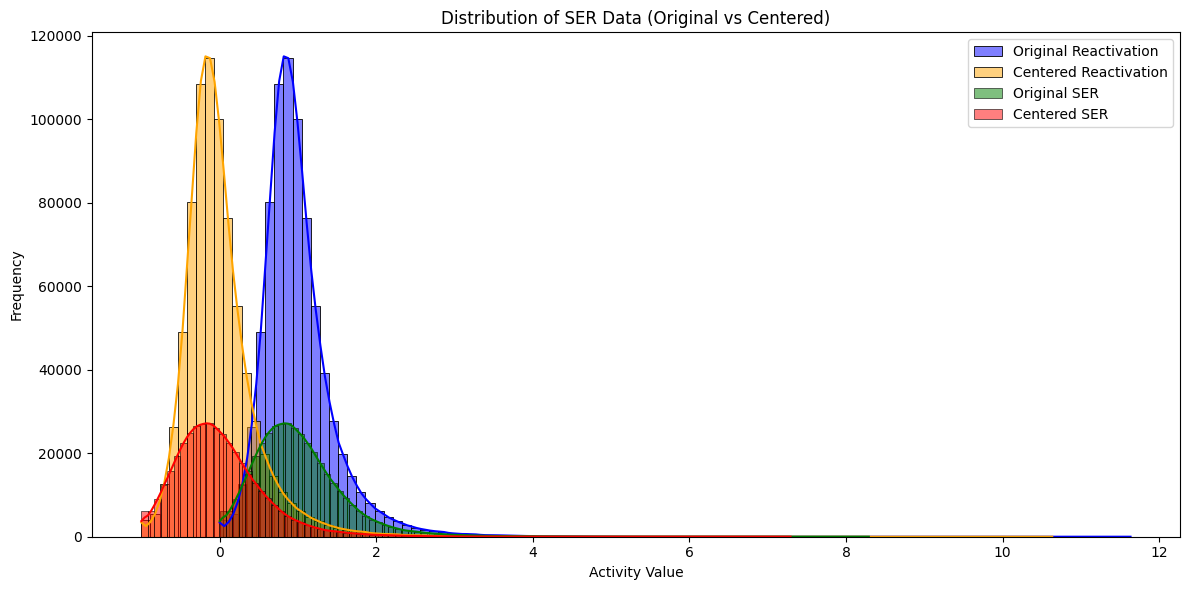

In [6]:
# Flatten the data for plotting
original_r_flat = reacts_ordered.flatten()
centered_r_flat = reacts_centered.flatten()
original_cs_flat = sers_ordered.flatten()
centered_cs_flat = SER_centered.flatten()

# Plot the distributions
plt.figure(figsize=(12, 6))

# Plot original vs centered reactivation data
sns.histplot(original_r_flat, bins=100, alpha=0.5, label='Original Reactivation', color='blue', kde=True)
sns.histplot(centered_r_flat, bins=100, alpha=0.5, label='Centered Reactivation', color='orange', kde=True)
plt.title("Distribution of Reactivation Data (Original vs Centered)")
plt.xlabel("Activity Value")
plt.ylabel("Frequency")
plt.legend()

# Plot original vs centered SER data
sns.histplot(original_cs_flat, bins=100, alpha=0.5, label='Original SER', color='green', kde=True)
sns.histplot(centered_cs_flat, bins=100, alpha=0.5, label='Centered SER', color='red', kde=True)
plt.title("Distribution of SER Data (Original vs Centered)")
plt.xlabel("Activity Value")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

PCA Analysis for Reactivation Data:


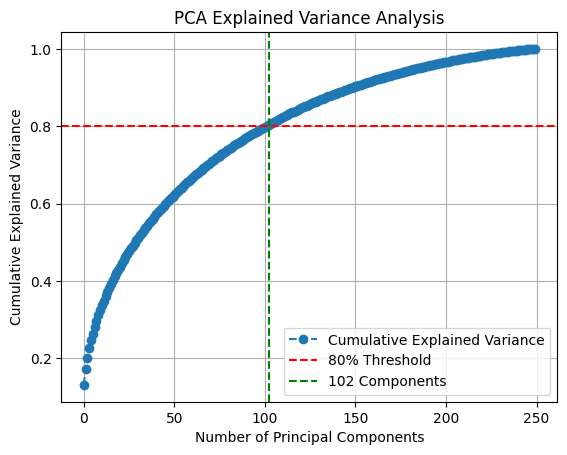

Number of components to explain 80% variance: 102

PCA Analysis for SER Data:


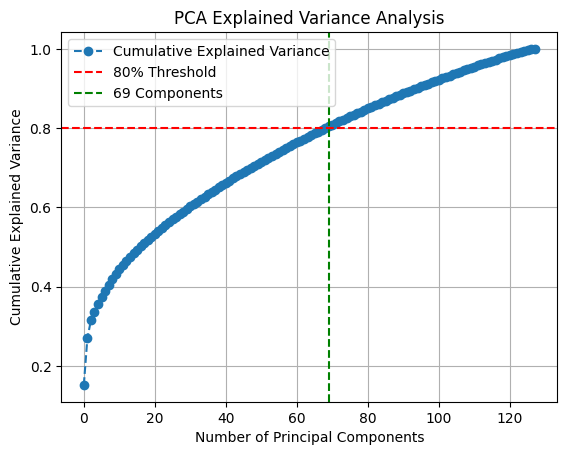

Number of components to explain 80% variance: 69
(250, 102) (128, 69)


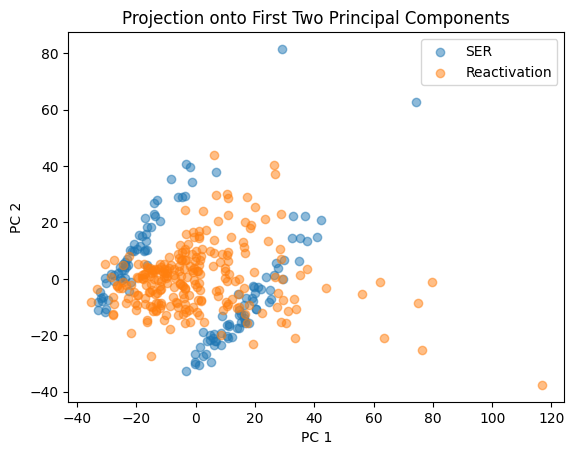

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Function to perform PCA and analyze explained variance
def perform_pca(data, explained_variance_threshold=0.80):
    """
    Performs PCA on the input data and determines the number of components 
    needed to explain the given variance threshold.

    Parameters:
    - data: 2D numpy array (samples, features)
    - explained_variance_threshold: float, target variance to explain (default = 0.80)

    Returns:
    - pca: trained PCA object
    - num_components: number of components required to reach threshold
    """

    # Standardize the data 
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Fit PCA model
    pca = PCA()
    pca.fit(data_scaled)

    # Calculate cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Find the number of components needed to explain desired variance
    num_components = np.argmax(cumulative_variance >= explained_variance_threshold) + 1

    # Project data onto top k principal components
    projected_data = pca.transform(data_scaled)[:, :num_components]

    # Plot explained variance ratio
    plt.plot(cumulative_variance, marker='o', linestyle='--', label='Cumulative Explained Variance')
    plt.axhline(y=explained_variance_threshold, color='r', linestyle='--', label=f'{explained_variance_threshold * 100:.0f}% Threshold')
    plt.axvline(x=num_components, color='g', linestyle='--', label=f'{num_components} Components')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance Analysis')
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Number of components to explain {explained_variance_threshold * 100:.0f}% variance: {num_components}")

    return pca, num_components, projected_data


# Perform PCA on reactivation data
print("PCA Analysis for Reactivation Data:")
pca_r, num_components_r, reactivation_projected = perform_pca(reacts_centered)

# Perform PCA on SER data
print("\nPCA Analysis for SER Data:")
pca_cs, num_components_cs, ser_projected = perform_pca(SER_centered)

print(reactivation_projected.shape, ser_projected.shape)

plt.scatter(ser_projected[:, 0], ser_projected[:, 1], alpha=0.5, label="SER")
plt.scatter(reactivation_projected[:, 0], reactivation_projected[:, 1], alpha=0.5, label="Reactivation")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.title("Projection onto First Two Principal Components")
plt.show()


Block: 20 trials - Components to explain 80% variance: 11
Block: 20 trials - Components to explain 80% variance: 12


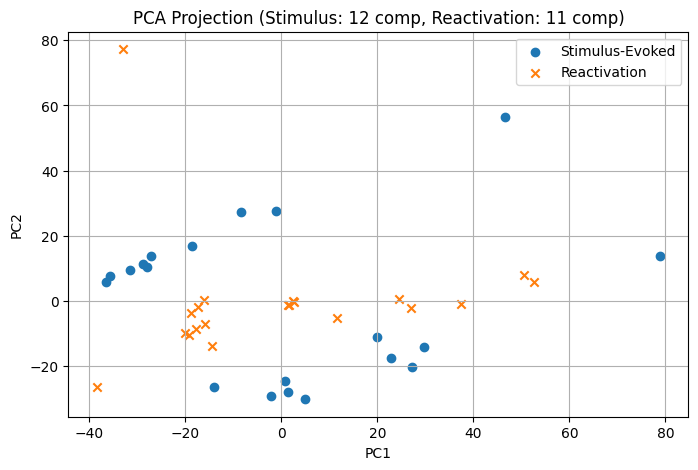

Block: 20 trials - Components to explain 80% variance: 11
Block: 20 trials - Components to explain 80% variance: 13


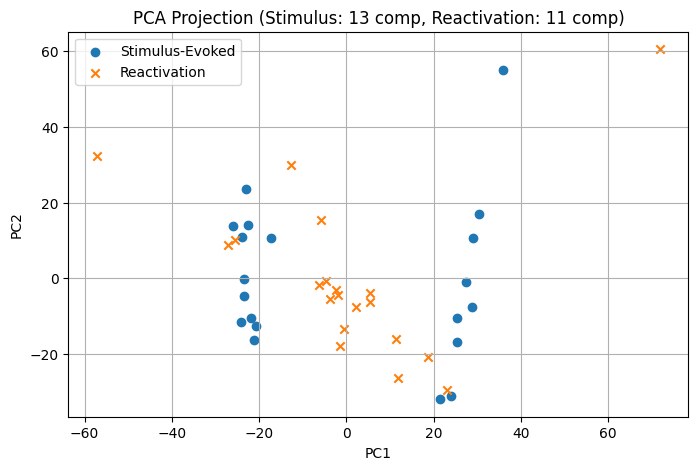

Block: 20 trials - Components to explain 80% variance: 12
Block: 20 trials - Components to explain 80% variance: 13


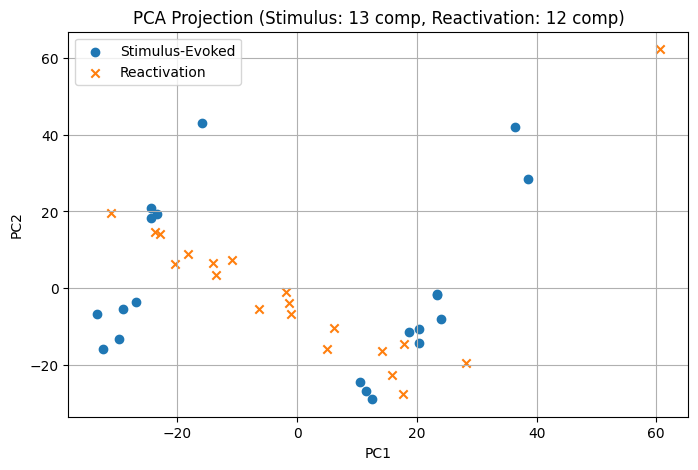

Block: 20 trials - Components to explain 80% variance: 12
Block: 20 trials - Components to explain 80% variance: 12


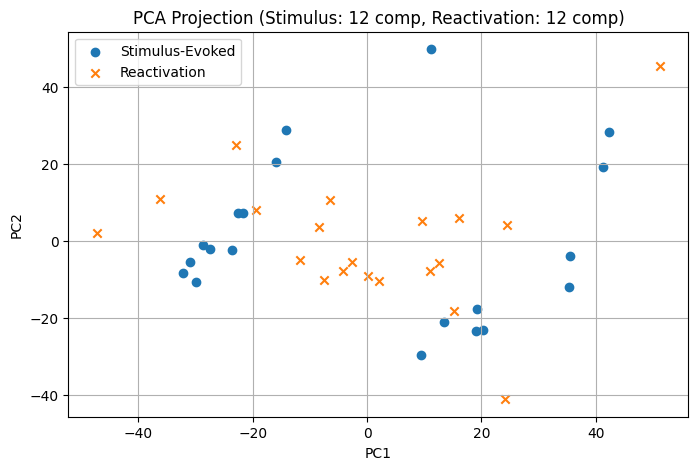

Block: 20 trials - Components to explain 80% variance: 11
Block: 20 trials - Components to explain 80% variance: 13


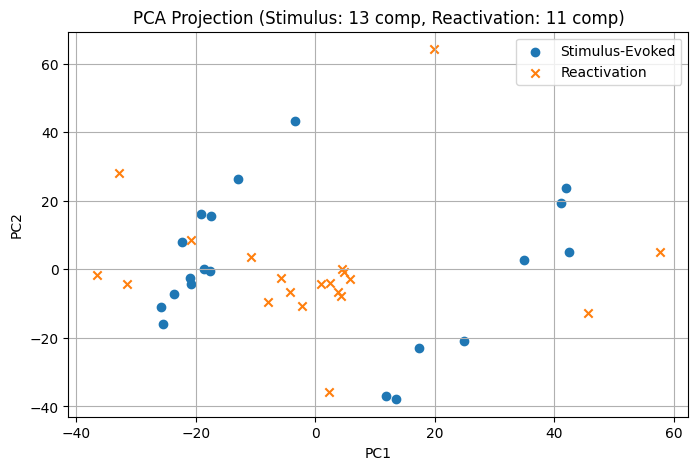

Block: 20 trials - Components to explain 80% variance: 12
Block: 28 trials - Components to explain 80% variance: 18


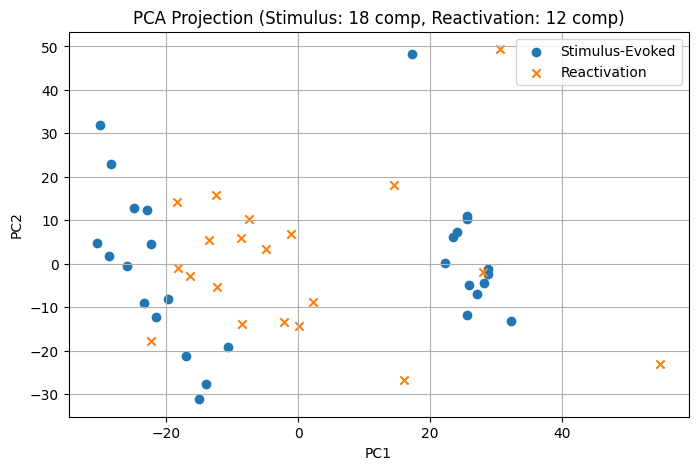

Block: 20 trials - Components to explain 80% variance: 11
Block: 28 trials - Components to explain 80% variance: 18


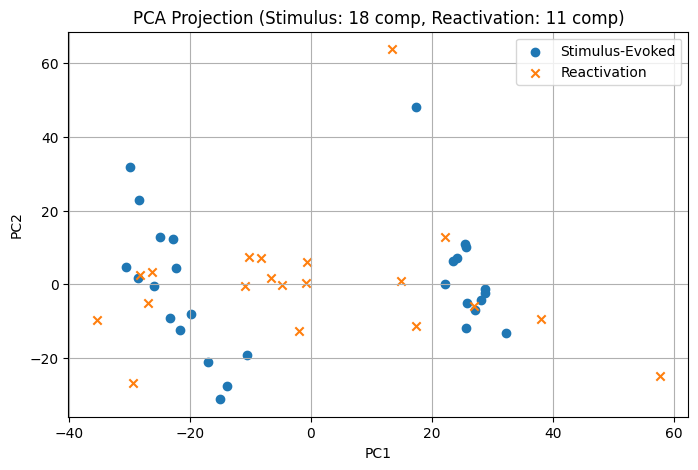

Block: 20 trials - Components to explain 80% variance: 11
Block: 28 trials - Components to explain 80% variance: 18


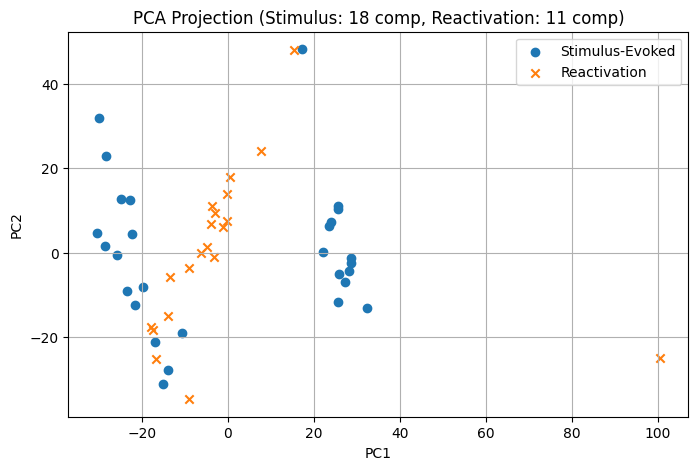

Block: 20 trials - Components to explain 80% variance: 11
Block: 28 trials - Components to explain 80% variance: 18


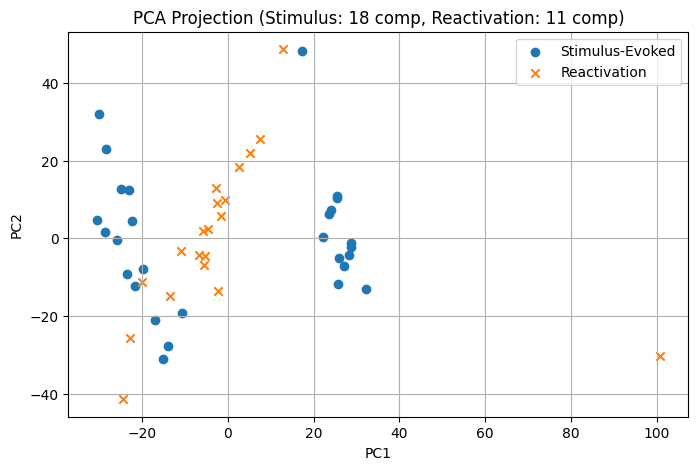

Block: 20 trials - Components to explain 80% variance: 11
Block: 28 trials - Components to explain 80% variance: 18


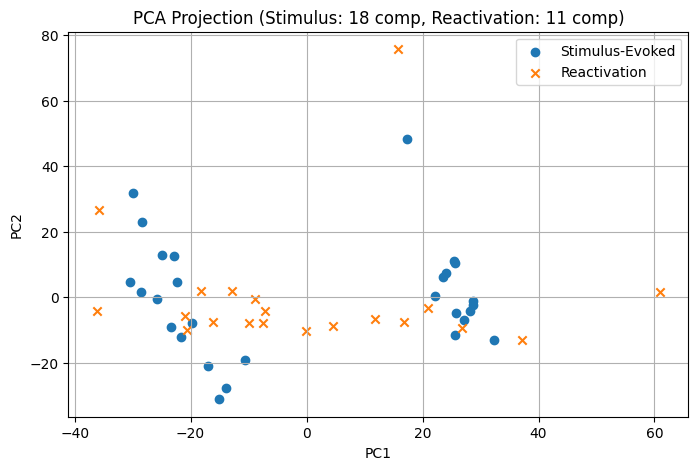

Block: 20 trials - Components to explain 80% variance: 12
Block: 28 trials - Components to explain 80% variance: 18


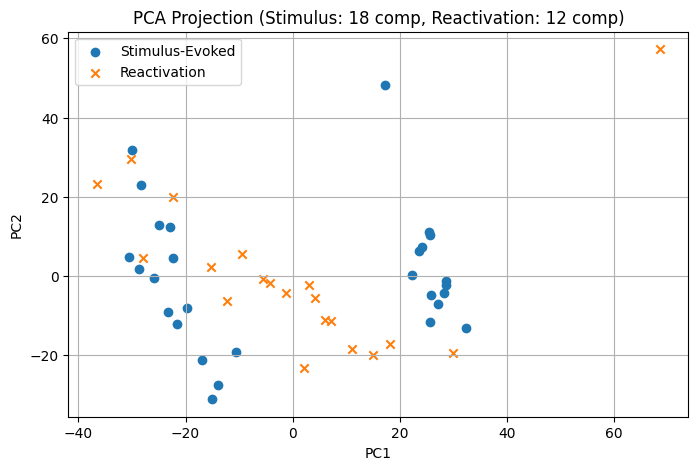

Block: 20 trials - Components to explain 80% variance: 11
Block: 28 trials - Components to explain 80% variance: 18


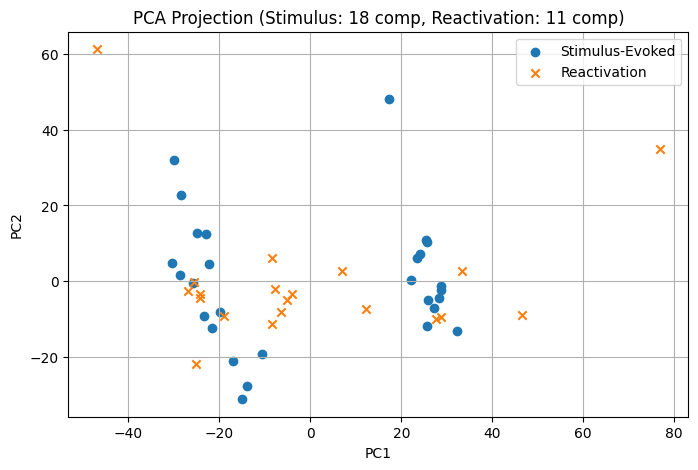

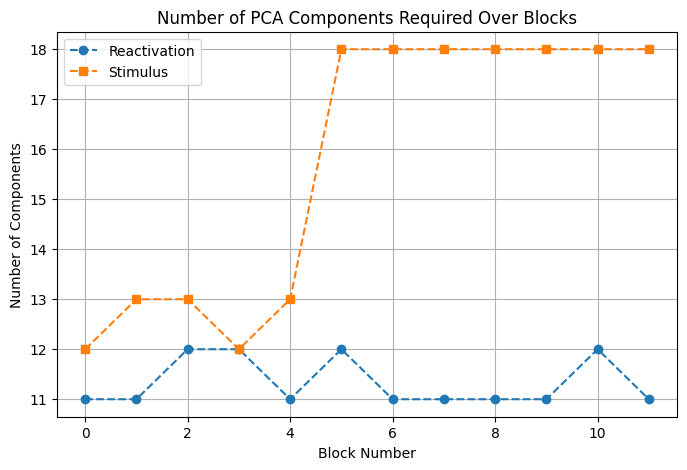

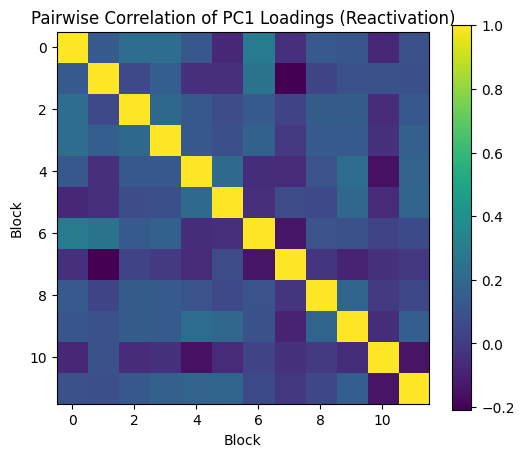

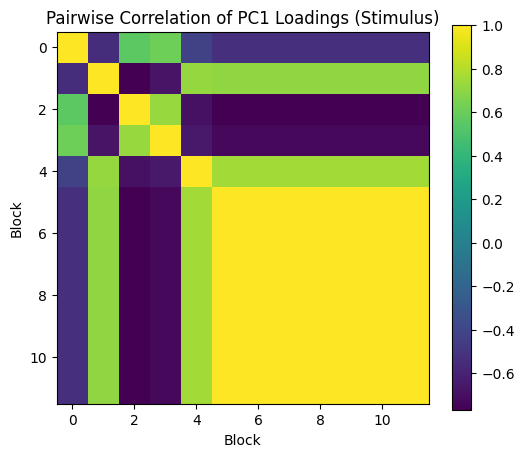

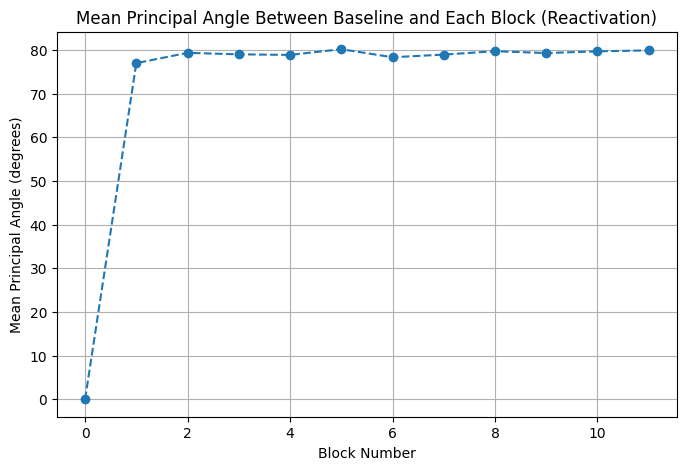

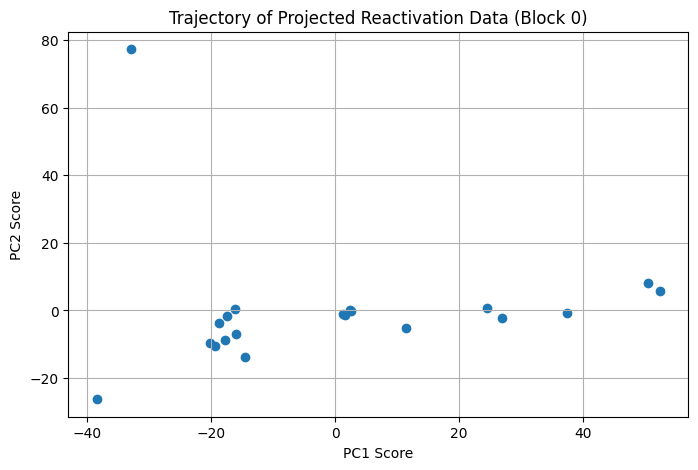

Running PCA on the full reactivation dataset:
Block: 250 trials - Components to explain 80% variance: 102

Running PCA on the full stimulus dataset:
Block: 128 trials - Components to explain 80% variance: 69


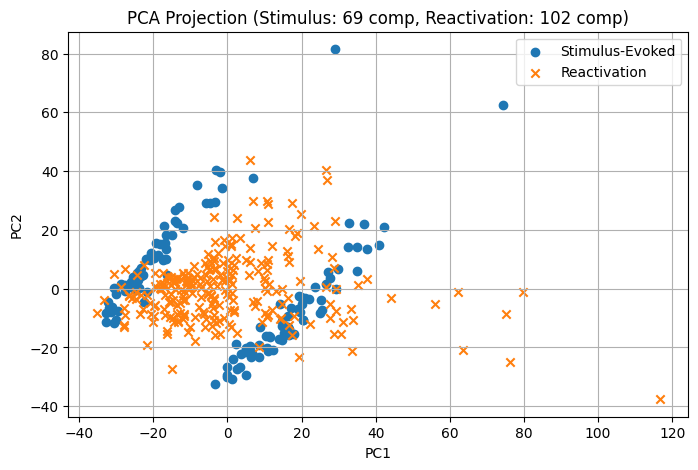

Running PCA on the full reactivation dataset:
Block: 378 trials - Components to explain 80% variance: 148

Running PCA on the full stimulus dataset:
Block: 378 trials - Components to explain 80% variance: 148


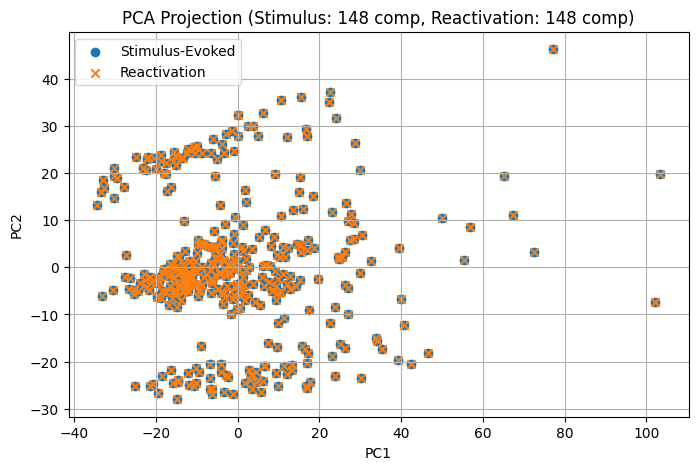

In [8]:
import scipy.linalg

#  PCA function with component info
def perform_pca(data, explained_variance_threshold=0.80, top_n=10):
    """
    Performs PCA on the input data, stores component analysis in a dataset,
    and determines the number of components needed to explain the given variance threshold.
    
    Parameters:
      - data: 2D numpy array (trials, neurons)
      - explained_variance_threshold: float, target variance to explain 
      - top_n: int, number of top contributing neurons to include per component
    
    Returns:
      - pca: trained PCA object
      - num_components: number of components required to reach threshold
      - projected_data: data projected onto the top principal components
      - components_info: list of dictionaries containing component analysis
    """
    # Standardize the data
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Fit PCA model
    pca = PCA()
    pca.fit(data_scaled)

    # Calculate cumulative explained variance
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Find the number of components needed to explain desired variance
    num_components = np.argmax(cumulative_variance >= explained_variance_threshold) + 1

    # Project data onto top k principal components
    projected_data = pca.transform(data_scaled)[:, :num_components]

    # Store component analysis
    components_info = []
    for i in range(num_components):
        component = pca.components_[i]
        # Find indices of top_n neurons with highest absolute contributions
        top_neuron_indices = np.argsort(np.abs(component))[-top_n:][::-1]
        top_neurons = [{"neuron_index": int(idx), "weight": float(component[idx])} 
                       for idx in top_neuron_indices]
        component_data = {
            "component_number": i + 1,
            "explained_variance_ratio": float(pca.explained_variance_ratio_[i]),
            "top_neurons": top_neurons
        }
        components_info.append(component_data)

    # Plot cumulative explained variance for this block
    #plt.figure(figsize=(8, 5))
    #plt.plot(cumulative_variance, marker='o', linestyle='--', label='Cumulative Explained Variance')
    #plt.axhline(y=explained_variance_threshold, color='r', linestyle='--', 
                #label=f'{explained_variance_threshold * 100:.0f}% Threshold')
    #plt.axvline(x=num_components-1, color='g', linestyle='--', 
                #label=f'{num_components} Components')
    #plt.xlabel('Number of Principal Components')
    #plt.ylabel('Cumulative Explained Variance')
    #plt.title('PCA Explained Variance Analysis')
    #plt.legend()
    #plt.grid()
    #plt.show()

    print(f"Block: {data.shape[0]} trials - Components to explain {explained_variance_threshold * 100:.0f}% variance: {num_components}")
    return pca, num_components, projected_data, components_info

#  PCA plot 
def plot_pca(stim_projected, react_projected, num_components_stim, num_components_react):
    """
    Plots the projected data from stimulus and reactivation side by side.
    """
    plt.figure(figsize=(8, 5))
    plt.scatter(stim_projected[:, 0], stim_projected[:, 1], label='Stimulus-Evoked')
    plt.scatter(react_projected[:, 0], react_projected[:, 1], label='Reactivation', marker='x')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"PCA Projection (Stimulus: {num_components_stim} comp, Reactivation: {num_components_react} comp)")
    plt.legend()
    plt.grid()
    plt.show()

# analyze PCA over trial blocks 
def analyze_pca_over_trials(reacts_ordered, sers_ordered, block_size=20, explained_variance_threshold=0.80, top_n=10):
    """
    Divides the reactivation and stimulus data into trial blocks and runs several analyses.
    
    For the reactivation data, we use blocks of size `block_size`. For stimulus data, if the current
    block's start trial is >= 100, we always use sers_ordered[100:, :] (as it has fewer trials overall).
    
    Analyses include:
      - Tracking the number of PCA components required over blocks.
      - Comparing PC1 loadings similarity across blocks.
      - Comparing PCA subspaces (using principal angles) between baseline and each block.
      - Trajectory analysis of the projected scores in a selected block.
      
    Returns a list of dictionaries with PCA results for each block.
    """
    n_trials_react = reacts_ordered.shape[0]
    n_blocks = n_trials_react // block_size

    results = []

    # Process each block for reactivation and corresponding stimulus data
    for block in range(n_blocks):
        start = block * block_size
        end = start + block_size
        react_block = reacts_ordered[start:end, :]
        
        # For stimulus data: if the block's start is before trial 100, slice normally;
        # if not, use sers_ordered[100:, :].
        if start < 100:
            ser_block = sers_ordered[start:end, :]
        else:
            ser_block = sers_ordered[100:, :]
        
        # Run PCA for reactivation and stimulus data blocks
        pca_r, num_components_r, projected_react, comp_info_r = perform_pca(react_block, explained_variance_threshold, top_n)
        pca_cs, num_components_cs, projected_ser, comp_info_cs = perform_pca(ser_block, explained_variance_threshold, top_n)

        results.append({
            "block": block,
            "start_trial": start,
            "end_trial": end,
            "num_components_react": num_components_r,
            "num_components_stim": num_components_cs,
            "explained_variance_react": [comp['explained_variance_ratio'] for comp in comp_info_r],
            "explained_variance_stim": [comp['explained_variance_ratio'] for comp in comp_info_cs],
            "pc1_loadings_react": pca_r.components_[0],  # First principal component loadings
            "pc1_loadings_stim": pca_cs.components_[0],
            "projected_react": projected_react,
            "projected_stim": projected_ser,
            "pca_components_react": pca_r.components_[:num_components_r],  # All components used
            "pca_components_stim": pca_cs.components_[:num_components_cs]
        })
        
        # (Optional) Plot PCA projections for this block
        plot_pca(projected_ser, projected_react, num_components_cs, num_components_r)

    # Track number of components over blocks
    blocks = [res["block"] for res in results]
    num_components_react = [res["num_components_react"] for res in results]
    num_components_stim = [res["num_components_stim"] for res in results]

    plt.figure(figsize=(8, 5))
    plt.plot(blocks, num_components_react, marker='o', linestyle='--', label='Reactivation')
    plt.plot(blocks, num_components_stim, marker='s', linestyle='--', label='Stimulus')
    plt.xlabel("Block Number")
    plt.ylabel("Number of Components")
    plt.title("Number of PCA Components Required Over Blocks")
    plt.legend()
    plt.grid()
    plt.show()

    # Compare PC1 loadings across blocks (Pairwise Correlation)
    # For reactivation data:
    pc1_react = np.array([res["pc1_loadings_react"] for res in results])
    n = pc1_react.shape[0]
    corr_matrix_react = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            corr_matrix_react[i, j] = np.corrcoef(pc1_react[i], pc1_react[j])[0, 1]

    plt.figure(figsize=(6, 5))
    plt.imshow(corr_matrix_react, cmap='viridis', interpolation='nearest')
    plt.title("Pairwise Correlation of PC1 Loadings (Reactivation)")
    plt.xlabel("Block")
    plt.ylabel("Block")
    plt.colorbar()
    plt.show()

    # For stimulus data:
    pc1_stim = np.array([res["pc1_loadings_stim"] for res in results])
    corr_matrix_stim = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            corr_matrix_stim[i, j] = np.corrcoef(pc1_stim[i], pc1_stim[j])[0, 1]

    plt.figure(figsize=(6, 5))
    plt.imshow(corr_matrix_stim, cmap='viridis', interpolation='nearest')
    plt.title("Pairwise Correlation of PC1 Loadings (Stimulus)")
    plt.xlabel("Block")
    plt.ylabel("Block")
    plt.colorbar()
    plt.show()

    # Compare each block's reactivation PCA subspace to the baseline block (block 0)
    baseline = results[0]["pca_components_react"]
    subspace_angles = []
    for res in results:
        current = res["pca_components_react"]
        # Use the minimum number of components between baseline and current block
        k = min(baseline.shape[0], current.shape[0])
        # scipy.linalg.subspace_angles expects matrices with shape (n_features, k)
        # so we take the transpose of the top-k component matrices.
        angles = scipy.linalg.subspace_angles(baseline[:k, :].T, current[:k, :].T)
        # Use the mean angle (in degrees) as a summary metric
        mean_angle = np.degrees(np.mean(angles))
        subspace_angles.append(mean_angle)

    plt.figure(figsize=(8, 5))
    plt.plot(blocks, subspace_angles, marker='o', linestyle='--')
    plt.xlabel("Block Number")
    plt.ylabel("Mean Principal Angle (degrees)")
    plt.title("Mean Principal Angle Between Baseline and Each Block (Reactivation)")
    plt.grid()
    plt.show()

    # For a selected block, plot the trajectory using the first two PCs.
    selected_block = results[0]
    proj_data = selected_block["projected_react"]
    plt.figure(figsize=(8, 5))
    plt.scatter(proj_data[:, 0], proj_data[:, 1])
    plt.xlabel("PC1 Score")
    plt.ylabel("PC2 Score")
    plt.title("Trajectory of Projected Reactivation Data (Block 0)")
    plt.grid()
    plt.show()

    return results

# full dataset PCA analysis
def full_dataset_pca(reacts_ordered, sers_ordered, explained_variance_threshold=0.80, top_n=10):
    """
    Runs PCA on the entire reactivation and stimulus datasets (without dividing into blocks),
    and plots the PCA projection.
    
    Parameters:
      - reacts_ordered: 2D numpy array (trials, neurons) for reactivation data.
      - sers_ordered: 2D numpy array (trials, neurons) for stimulus data.
      - explained_variance_threshold: float, target variance to explain.
      - top_n: int, number of top contributing neurons to include per component.
    
    Returns:
      A dictionary containing the PCA results for the full datasets.
    """
    print("Running PCA on the full reactivation dataset:")
    pca_r, num_components_r, projected_react, components_info_r_all = perform_pca(reacts_ordered, explained_variance_threshold, top_n)
    
    print("\nRunning PCA on the full stimulus dataset:")
    pca_cs, num_components_cs, projected_ser, components_info_cs_all = perform_pca(sers_ordered, explained_variance_threshold, top_n)
    
    # Plot the full dataset PCA projection (using the first two PCs)
    plot_pca(projected_ser, projected_react, num_components_cs, num_components_r)
    
    return {
      "reactivation": {
         "pca": pca_r,
         "num_components": num_components_r,
         "projected_data": projected_react,
         "components_info": components_info_r_all
      },
      "stimulus": {
         "pca": pca_cs,
         "num_components": num_components_cs,
         "projected_data": projected_ser,
         "components_info": components_info_cs_all
      }
    }

all_dat = np.concatenate([reacts_centered, SER_centered])

if __name__ == "__main__":
    block_results = analyze_pca_over_trials(reacts_centered, SER_centered, 
                                            block_size=20, 
                                            explained_variance_threshold=0.80, 
                                            top_n=10)
    
    # Run PCA on the full datasets (not divided by blocks)
    full_results = full_dataset_pca(reacts_centered, SER_centered, 
                                    explained_variance_threshold=0.80, 
                                    top_n=10)
    

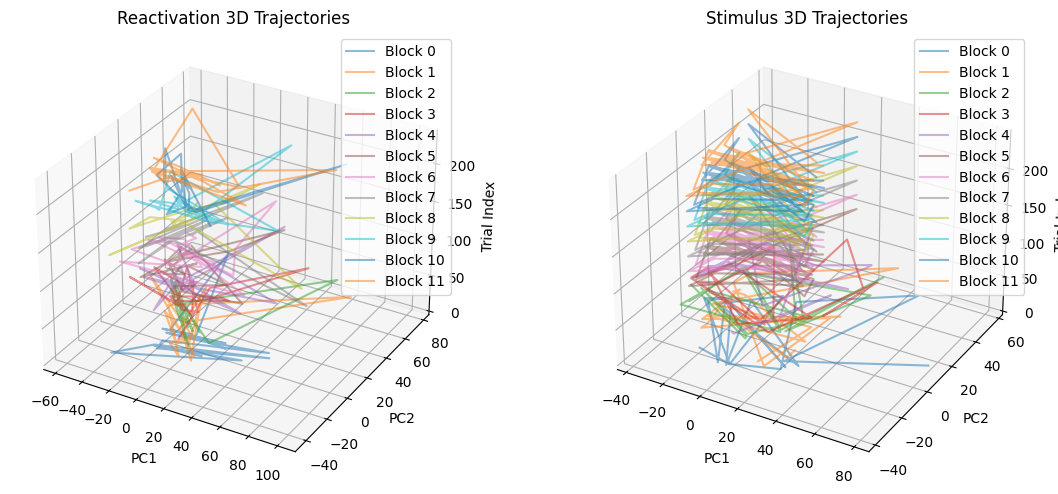

In [9]:
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting


def plot_3d_trajectories_over_blocks(results):
    """
    Plots 3D trajectories for both reactivation and stimulus data across blocks.
    The x-axis = PC1, y-axis = PC2, z-axis = trial index (or a pseudo-time).
    
    Parameters:
      - results: list of dictionaries returned by analyze_pca_over_trials.
                 Each dict must contain 'block', 'start_trial', 'end_trial',
                 'projected_react', and 'projected_stim'.
    """
    fig = plt.figure(figsize=(12, 5))
    
    # --- 3D Plot for Reactivation ---
    ax1 = fig.add_subplot(121, projection='3d')
    for block_res in results:
        block_num = block_res["block"]
        start = block_res["start_trial"]
        end = block_res["end_trial"]
        proj_data = block_res["projected_react"]
        
        # We'll plot PC1 vs PC2 and use trial index for z
        xvals = proj_data[:, 0]  # PC1
        yvals = proj_data[:, 1]  # PC2
        
        # Create a range of trial indices for this block
        # e.g. for block 0 (trials 0:20), z goes from 0..19
        zvals = np.arange(start, end)  
        
        # Plot the block as a line in 3D
        ax1.plot(xvals, yvals, zvals, alpha = .5, label=f'Block {block_num}')
    
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_zlabel('Trial Index')
    ax1.set_title('Reactivation 3D Trajectories')
    ax1.legend()
    
    # --- 3D Plot for Stimulus ---
    ax2 = fig.add_subplot(122, projection='3d')
    for block_res in results:
        block_num = block_res["block"]
        start = block_res["start_trial"]
        end = block_res["end_trial"]
        proj_data = block_res["projected_stim"]
        
        xvals = proj_data[:, 0]
        yvals = proj_data[:, 1]
        
        # If you always slice sers_ordered[100:, :] for blocks >= 100,
        # the shape of proj_data might be bigger than block_size. 
        # We'll just label them starting at 'start' so it's clear which block they belong to.
        zvals = np.arange(proj_data.shape[0]) + start
        
        ax2.plot(xvals, yvals, zvals, alpha=.5, label=f'Block {block_num}')
    
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    ax2.set_zlabel('Trial Index')
    ax2.set_title('Stimulus 3D Trajectories')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_3d_trajectories_over_blocks(block_results)


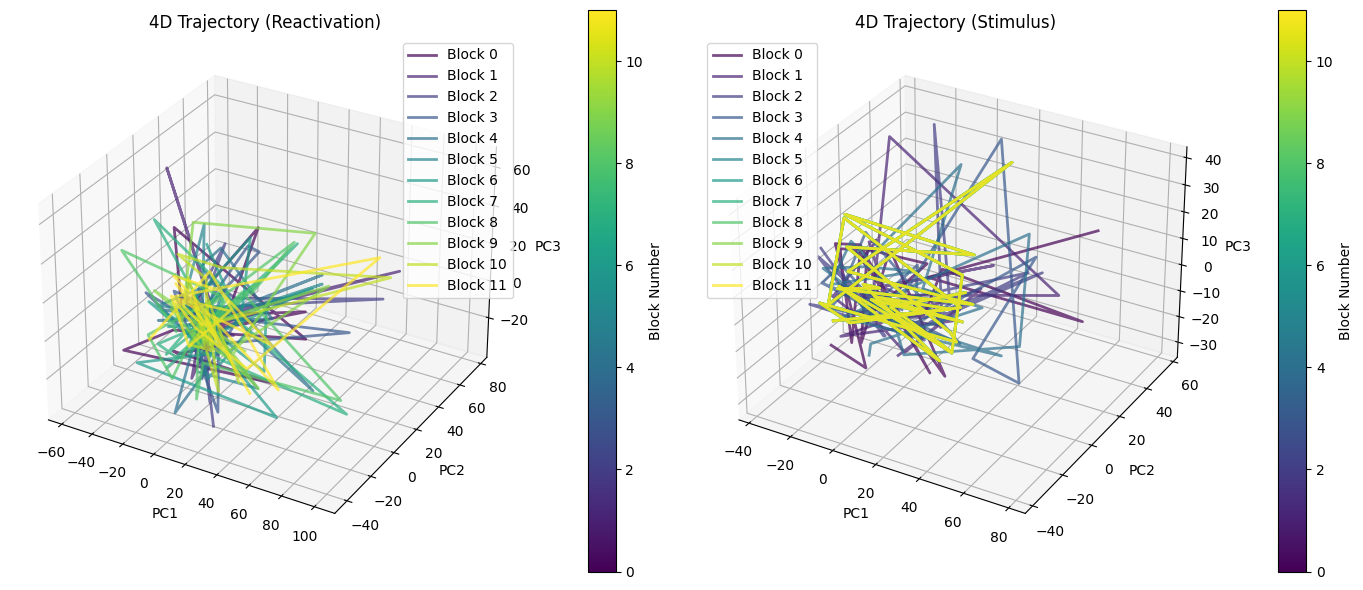

In [14]:
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
import matplotlib.cm as cm

def plot_4d_trajectories_over_blocks_separate(results, alpha=0.7):
    """
    Plots two 3D trajectories with a 4D twist—one for reactivation data and one for stimulus data.
    The first three principal components (PC1, PC2, PC3) are used for the spatial axes, while
    the block/time dimension is encoded as color.
    
    Parameters:
      - results: list of dictionaries returned by analyze_pca_over_trials.
                 Each dictionary must contain:
                   'block',
                   'projected_react' (with at least 3 components),
                   'projected_stim' (with at least 3 components).
      - alpha: float (0 to 1) controlling line transparency.
    """
    fig = plt.figure(figsize=(14, 6))
    
    # Create subplots for reactivation (left) and stimulus (right)
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    
    # Set up colormap for block encoding
    n_blocks = len(results)
    cmap = get_cmap('viridis')
    norm = Normalize(vmin=0, vmax=n_blocks-1)
    
    # Plot each block for both reactivation and stimulus
    for res in results:
        block = res["block"]
        color = cmap(norm(block))
        
        # --- Reactivation plot ---
        proj_react = res["projected_react"]
        if proj_react.shape[1] < 3:
            print("Not enough components in reactivation data for 3D plot. Need at least 3 components.")
            return
        x_r = proj_react[:, 0]  # PC1
        y_r = proj_react[:, 1]  # PC2
        z_r = proj_react[:, 2]  # PC3
        ax1.plot(x_r, y_r, z_r, color=color, alpha=alpha, linewidth=2, label=f'Block {block}')
        
        # --- Stimulus plot ---
        proj_stim = res["projected_stim"]
        if proj_stim.shape[1] < 3:
            print("Not enough components in stimulus data for 3D plot. Need at least 3 components.")
            return
        x_s = proj_stim[:, 0]  # PC1
        y_s = proj_stim[:, 1]  # PC2
        z_s = proj_stim[:, 2]  # PC3
        ax2.plot(x_s, y_s, z_s, color=color, alpha=alpha, linewidth=2, label=f'Block {block}')
    
    # --- Reactivation plot formatting ---
    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax1.set_zlabel('PC3')
    ax1.set_title('4D Trajectory (Reactivation)')
    sm1 = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm1.set_array([])
    cbar1 = plt.colorbar(sm1, ax=ax1, pad=0.1)
    cbar1.set_label('Block Number')
    ax1.legend()
    
    # --- Stimulus plot formatting ---
    ax2.set_xlabel('PC1')
    ax2.set_ylabel('PC2')
    ax2.set_zlabel('PC3')
    ax2.set_title('4D Trajectory (Stimulus)')
    sm2 = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm2.set_array([])
    cbar2 = plt.colorbar(sm2, ax=ax2, pad=0.1)
    cbar2.set_label('Block Number')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_4d_trajectories_over_blocks_separate(block_results, alpha=0.7)

